In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

<Onto 99 concepts, 4 roles, 287 axioms>

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data[0],
    'X': data[1],
    'y': data[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [7]:
rng = np.random.default_rng(seed)
T.manual_seed(seed)
reasoner = NeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train(data_tr, data_vl, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=30, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002)

head params 3293
embs params 1430
train epoch 00/30 | batch 025/192 | loss 0.8012 | elapsed 0.21s

train epoch 00/30 | batch 193/192 | loss 0.8001 | val loss 0.8007 | acc 0.0946 | f1 0.1729 | prec 0.0946 | recall 1.0000 | roc auc 0.4431 | pr auc 0.0823 | elapsed 1.51s
train epoch 01/30 | batch 193/192 | loss 0.3903 | val loss 0.2037 | acc 0.9255 | f1 0.3504 | prec 1.0000 | recall 0.2124 | roc auc 0.8670 | pr auc 0.6831 | elapsed 2.50s
train epoch 02/30 | batch 193/192 | loss 0.1577 | val loss 0.1378 | acc 0.9603 | f1 0.7461 | prec 0.9444 | recall 0.6166 | roc auc 0.9127 | pr auc 0.8232 | elapsed 3.04s
train epoch 03/30 | batch 193/192 | loss 0.1280 | val loss 0.1291 | acc 0.9613 | f1 0.7628 | prec 0.9071 | recall 0.6580 | roc auc 0.9223 | pr auc 0.8406 | elapsed 2.37s
train epoch 04/30 | batch 193/192 | loss 0.1223 | val loss 0.1293 | acc 0.9603 | f1 0.7538 | prec 0.9118 | recall 0.6425 | roc auc 0.9235 | pr auc 0.8401 | elapsed 2.62s
train epoch 05/30 | batch 193/192 | loss 0.1185 | val loss 0.1313 | acc 0.9603 | f1 0.7538 | prec 0.9118 | recall 0.6425 | roc auc 0.9228 | pr auc 0.8

             mean  std     micro
acc      0.960804  NaN  0.960804
prec     0.781095  NaN  0.781095
recall   0.813472  NaN  0.813472
f1       0.796954  NaN  0.796954
auc_roc  0.937471  NaN  0.937471
auc_pr   0.868683  NaN  0.868683


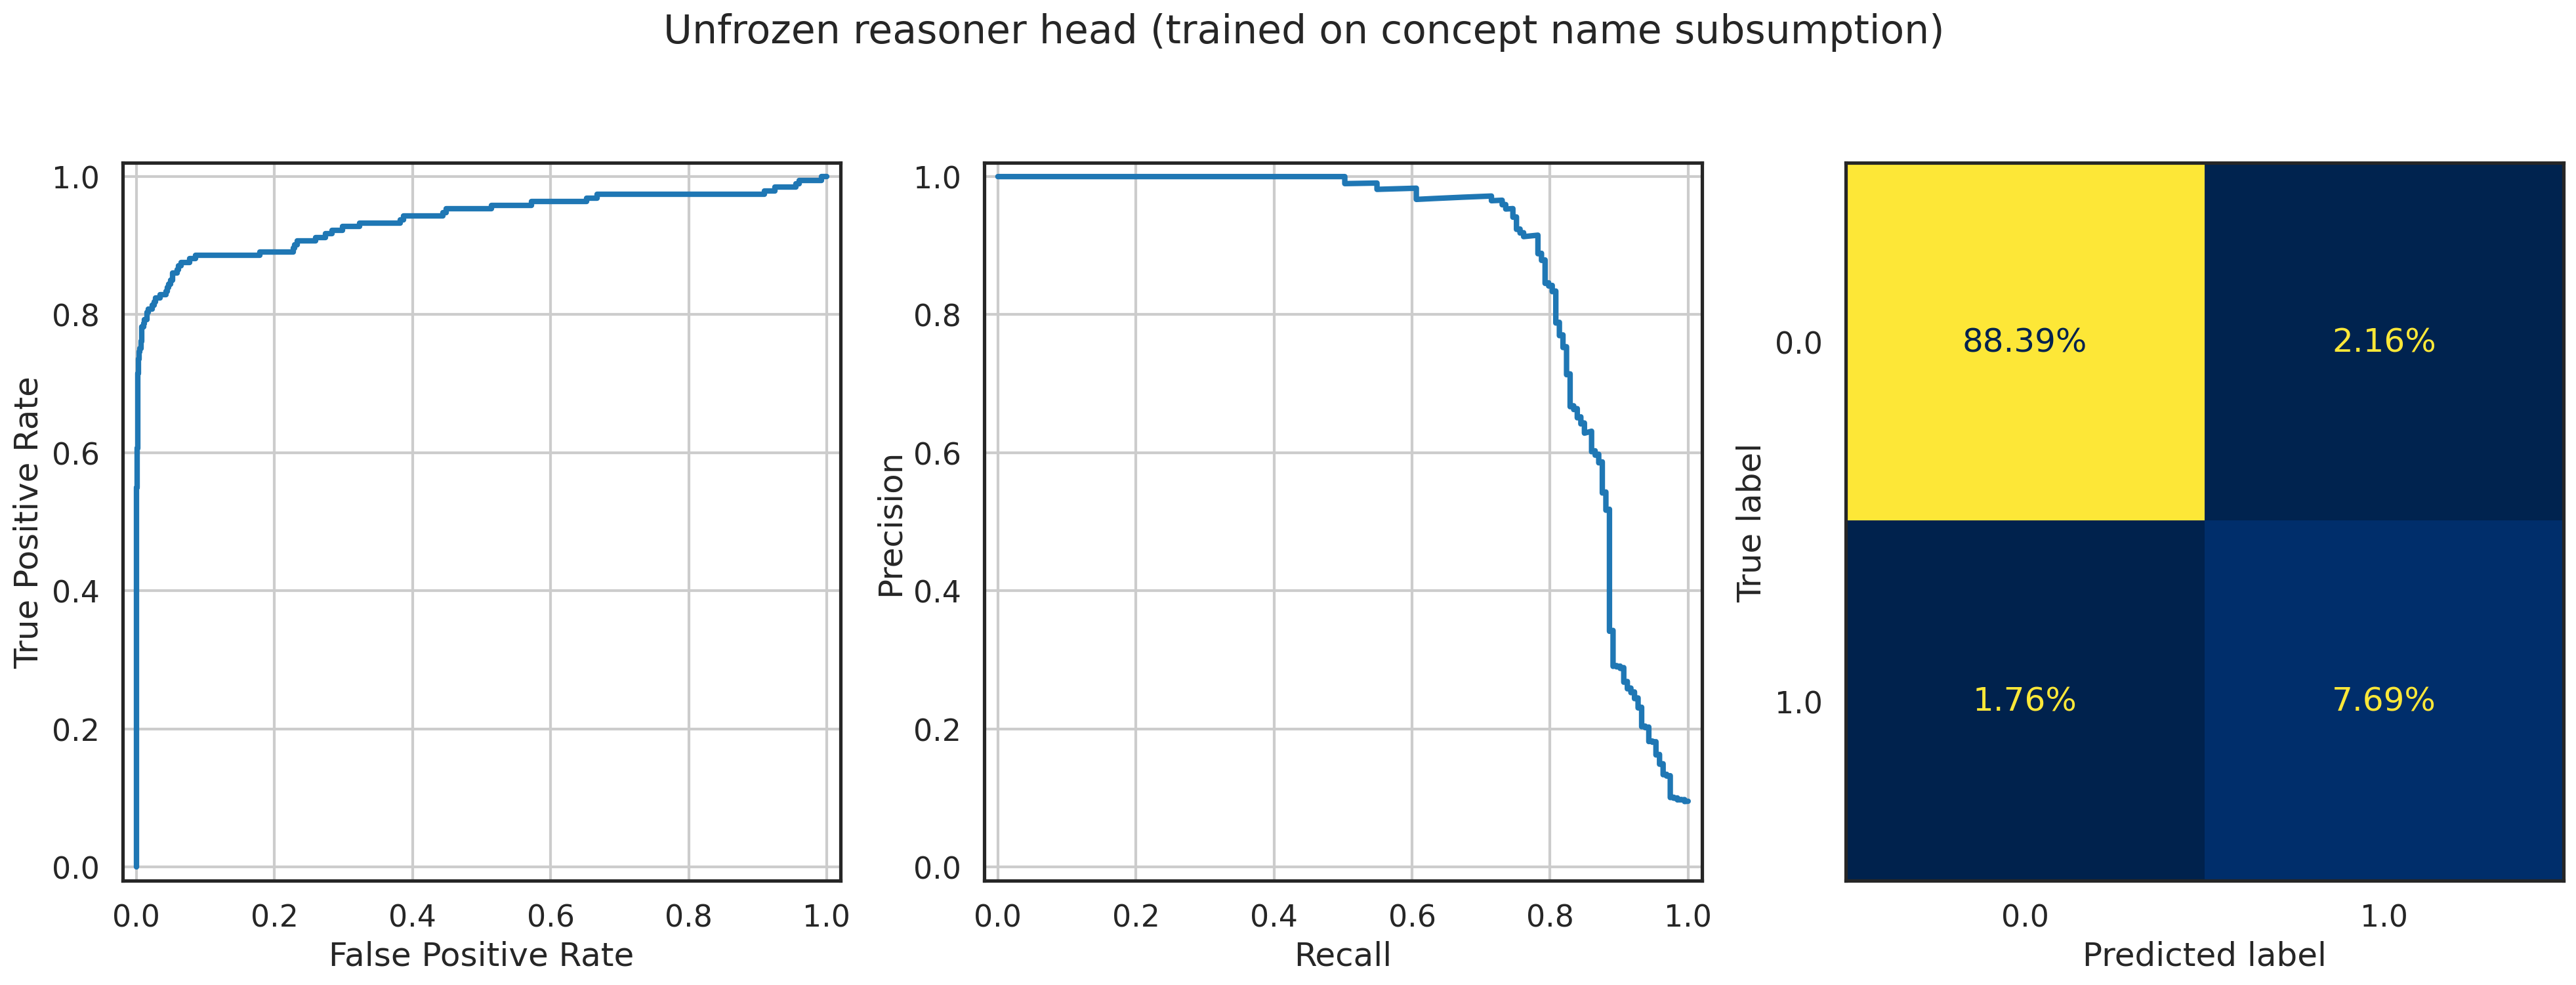

In [8]:
with T.no_grad():
    reasoner.eval()
    _, y_test, Y_te = eval_batch(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_test, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [9]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te = np.array(Y_te)
y_te = np.array(y_te)
X_te = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te - y_te) > 0.3

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te[błędne_predykcje],
    'Predykcja': Y_te[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

    Rekord  Prawdziwa Etykieta     Predykcja  Feature_0  Feature_1  Feature_2
0        4                 1.0  3.351192e-15          0          7          7
1       12                 0.0  3.411279e-01          0         80         63
2       13                 0.0  9.962155e-01          0         70         59
3       23                 0.0  6.471152e-01          0         65         63
4       48                 0.0  9.715476e-01          0         23         18
..     ...                 ...           ...        ...        ...        ...
84    1932                 0.0  9.718990e-01          0         87         92
85    1977                 0.0  9.180422e-01          0         76         60
86    1993                 1.0  1.560550e-10          0         35         35
87    2008                 0.0  8.919454e-01          0         84         28
88    2022                 0.0  6.449736e-01          0         85         81

[89 rows x 6 columns]
